# Обучение char-level языковой модели с помощью RNN

Установим модуль datasets, чтобы нам проще было работать с данными

In [1]:
!pip install datasets

Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/arsen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

In [5]:
# Загрузим датасет
dataset = load_dataset('IlyaGusev/gazeta', revision="v1.0")

No config specified, defaulting to: gazeta/default
Found cached dataset gazeta (/home/arsen/.cache/huggingface/datasets/IlyaGusev___gazeta/default/1.0.0/ef9349c3c0f3112ca4036520d76c4bc1b8a79d30bc29643c6cae5a094d44e457)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
sentences = []

for sentence in tqdm(dataset['validation']['text']):
    sentences.extend(
        [x.lower() for x in sent_tokenize(sentence, language='russian') if len(x) < 128]
        )

  0%|          | 0/5265 [00:00<?, ?it/s]

In [7]:
len(sentences)

122237

In [8]:
chars = Counter()

for sentence in tqdm(sentences):
    for char in sentence:
        chars[char] += 1

  0%|          | 0/122237 [00:00<?, ?it/s]

In [9]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 500

for char, cnt in chars.items():
    if cnt > counter_threshold:
        vocab.add(char)

In [10]:
len(vocab)

86

In [11]:
char2ind = {char: i for i, char in enumerate(vocab)}
ind2char = {i: char for char, i in char2ind.items()}

In [12]:
class CharDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = char2ind['<unk>']
        self.bos_id = char2ind['<bos>']
        self.eos_id = char2ind['<eos>']
        self.pad_id = char2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [char2ind.get(char, self.unk_id) for char in self.data[idx]] 
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [13]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=char2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)
    
    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [14]:
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.2)

train_dataset = CharDataset(train_sentences)
eval_dataset = CharDataset(eval_sentences)

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=256)

## Архитектура модели

In [15]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

## Train loop

In [51]:
def evaluate(model, criterion) -> float:
    """
    Calculate perplexity on validation dataloader.
    """

    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in eval_dataloader:
            print(model(batch['input_ids']))
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(
                logits, 
                batch['target_ids'].flatten()
                )
            print(batch['target_ids'])
            perplexity.append(torch.exp(loss).item())
    
    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

In [52]:
model = CharLM(hidden_dim=256, vocab_size=len(vocab)).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=char2ind['<pad>'])
optimizer = torch.optim.Adam(model.parameters())

In [53]:
num_epoch = 10
losses = []
perplexities = []

for epoch in range(num_epoch):
    epoch_losses = []
    model.train()
    for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch}:'):
        optimizer.zero_grad()
        logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
        loss = criterion(
            logits, batch['target_ids'].flatten())
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
    
    losses.append(sum(epoch_losses) / len(epoch_losses))
    perplexities.append(evaluate(model, criterion))

Training epoch 0::   0%|          | 0/382 [00:00<?, ?it/s]

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-1.2531,  4.8415, -4.0525,  ..., -3.1274, -4.8906,  0.2256],
         [-5.0380, -2.0457, -3.7983,  ..., -2.4867,  1.2943, -1.2433],
         ...,
         [ 0.1779,  1.6882, -1.4627,  ...,  0.5047, -1.7606,  3.2235],
         [ 0.1777,  1.6887, -1.4613,  ...,  0.5065, -1.7598,  3.2226],
         [ 0.1774,  1.6887, -1.4597,  ...,  0.5076, -1.7585,  3.2221]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.7791, -0.9014, -3.4796,  ..., -3.6006,  0.9061, -2.4454],
         [ 0.4500,  1.5323, -4.0642,  ..., -0.7193, -3.6776, -0.3226],
         ...,
         [ 0.2358,  1.6951, -1.4445,  ...,  0.4824, -1.7394,  3.2391],
         [ 0.2371,  1.6954, -1.4440,  ...,  0.4828, -1.7390,  3.2397],
         [ 0.2379,  1.6956, -1.4436,  ...,  0.4832, -1.7386,  3.2402]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.5343,  0.9344, -4.5524,  ..., -3

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.5343,  0.9344, -4.5524,  ..., -3.2939, -1.1607, -1.9356],
         [-2.1063,  2.2867, -2.7952,  ..., -2.2075, -1.3137, -0.0543],
         ...,
         [ 0.1865,  1.6852, -1.4445,  ...,  0.5199, -1.7472,  3.2206],
         [ 0.1873,  1.6853, -1.4445,  ...,  0.5192, -1.7468,  3.2214],
         [ 0.1885,  1.6855, -1.4445,  ...,  0.5185, -1.7463,  3.2218]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.7791, -0.9014, -3.4796,  ..., -3.6006,  0.9061, -2.4454],
         [-2.7107, -0.1763, -4.1961,  ..., -2.9584, -0.6271, -3.4847],
         ...,
         [ 0.0608,  1.6739, -1.4614,  ...,  0.5347, -1.7876,  3.1502],
         [ 0.0648,  1.6750, -1.4600,  ...,  0.5362, -1.7829,  3.1547],
         [ 0.0697,  1.6764, -1.4588,  ...,  0.5376, -1.7789,  3.1589]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-3.8715,  2.7684, -1.7844,  ..., -5

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [ 0.2609,  5.0907, -3.3715,  ..., -3.1852, -6.6387,  2.0075],
         [-7.0587, -0.5563, -3.8551,  ..., -3.2399, -2.0439, -1.2318],
         ...,
         [ 0.2294,  1.6911, -1.4421,  ...,  0.5000, -1.7396,  3.2394],
         [ 0.2297,  1.6912, -1.4421,  ...,  0.4999, -1.7396,  3.2396],
         [ 0.2297,  1.6912, -1.4421,  ...,  0.4997, -1.7395,  3.2396]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [ 0.2609,  5.0907, -3.3715,  ..., -3.1852, -6.6387,  2.0075],
         [-7.0587, -0.5563, -3.8551,  ..., -3.2399, -2.0439, -1.2318],
         ...,
         [ 0.2075,  1.6898, -1.4448,  ...,  0.5072, -1.7437,  3.2306],
         [ 0.2079,  1.6898, -1.4448,  ...,  0.5070, -1.7436,  3.2312],
         [ 0.2093,  1.6898, -1.4445,  ...,  0.5070, -1.7436,  3.2315]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-3.8715,  2.7684, -1.7844,  ..., -5

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-0.3786,  3.3077, -3.0711,  ..., -2.9803, -1.6917, -0.1577],
         [-1.6157, -1.5748, -3.1304,  ..., -2.7721,  1.3498,  1.0976],
         ...,
         [ 0.2236,  1.6913, -1.4497,  ...,  0.4948, -1.7472,  3.2382],
         [ 0.2233,  1.6914, -1.4490,  ...,  0.4954, -1.7466,  3.2381],
         [ 0.2230,  1.6918, -1.4485,  ...,  0.4958, -1.7465,  3.2378]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-0.4501,  6.2046, -2.6804,  ..., -3.0892, -5.2792,  1.3223],
         [-3.6284, -0.6460, -3.2585,  ..., -3.4747,  1.9919, -2.0561],
         ...,
         [ 0.1857,  1.6875, -1.4457,  ...,  0.5166, -1.7459,  3.2225],
         [ 0.1875,  1.6875, -1.4455,  ...,  0.5161, -1.7455,  3.2230],
         [ 0.1892,  1.6876, -1.4454,  ...,  0.5159, -1.7455,  3.2239]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-3.6559, -1.7552, -2.0872,  ..., -3

tensor([[[-3.4539e+00,  2.4373e+00, -6.1126e-01,  ..., -4.8714e+00,
          -3.0372e+00, -9.5423e-01],
         [-8.9725e-01,  1.8954e+00,  8.6243e-01,  ...,  9.3165e-01,
          -4.0286e-01, -1.0145e+00],
         [-1.7631e+00,  1.7389e+00,  5.5858e-01,  ...,  1.4022e+00,
          -5.6678e-01, -2.1749e+00],
         ...,
         [ 5.3743e-01,  1.4573e+00, -1.3764e+00,  ...,  4.7511e-01,
          -1.6335e+00,  3.1771e+00],
         [ 4.5886e-01,  1.4449e+00, -1.3697e+00,  ...,  5.3671e-01,
          -1.6827e+00,  3.1510e+00],
         [ 3.7037e-01,  1.4752e+00, -1.3787e+00,  ...,  5.3557e-01,
          -1.7206e+00,  3.1599e+00]],

        [[-3.4539e+00,  2.4373e+00, -6.1126e-01,  ..., -4.8714e+00,
          -3.0372e+00, -9.5423e-01],
         [ 1.5509e-01,  4.2320e+00, -3.0060e+00,  ..., -3.5868e+00,
          -1.0846e+00,  2.0469e+00],
         [-3.6981e+00, -7.9348e-01, -2.8799e+00,  ..., -2.7676e+00,
           2.9237e+00, -9.0379e-01],
         ...,
         [ 1.8117e-01,  1

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-1.9417,  4.0276, -3.9567,  ..., -3.5886, -3.4100,  2.1024],
         [-2.1654,  0.1656, -3.9563,  ..., -3.5343,  0.5959, -0.5739],
         ...,
         [ 0.2032,  1.6664, -1.4577,  ...,  0.5105, -1.7626,  3.2208],
         [ 0.1996,  1.6685, -1.4562,  ...,  0.5121, -1.7604,  3.2206],
         [ 0.1973,  1.6708, -1.4546,  ...,  0.5134, -1.7588,  3.2201]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [ 0.1551,  4.2320, -3.0060,  ..., -3.5868, -1.0846,  2.0469],
         [-3.6981, -0.7935, -2.8799,  ..., -2.7676,  2.9237, -0.9038],
         ...,
         [ 0.2258,  1.6905, -1.4426,  ...,  0.5017, -1.7398,  3.2382],
         [ 0.2260,  1.6905, -1.4425,  ...,  0.5016, -1.7398,  3.2383],
         [ 0.2264,  1.6905, -1.4425,  ...,  0.5015, -1.7397,  3.2384]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [ 0.2609,  5.0907, -3.3715,  ..., -3

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [ 0.6774,  5.4316, -3.1814,  ..., -3.7611, -6.1392,  1.0213],
         [ 0.5626,  6.2747, -3.0803,  ..., -2.6577, -6.3960,  3.4298],
         ...,
         [ 0.2160,  1.6900, -1.4437,  ...,  0.5051, -1.7415,  3.2347],
         [ 0.2163,  1.6901, -1.4437,  ...,  0.5047, -1.7414,  3.2349],
         [ 0.2169,  1.6902, -1.4436,  ...,  0.5045, -1.7413,  3.2351]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.5343,  0.9344, -4.5524,  ..., -3.2939, -1.1607, -1.9356],
         [-4.0169,  2.2281, -1.1748,  ..., -5.1936, -2.1543, -0.7408],
         ...,
         [ 0.1638,  1.6839, -1.4486,  ...,  0.5244, -1.7500,  3.2126],
         [ 0.1655,  1.6841, -1.4485,  ...,  0.5237, -1.7497,  3.2138],
         [ 0.1677,  1.6845, -1.4483,  ...,  0.5233, -1.7497,  3.2147]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-5.3145,  4.0417, -4.3845,  ..., -3

tensor([[[-3.4539e+00,  2.4373e+00, -6.1126e-01,  ..., -4.8714e+00,
          -3.0372e+00, -9.5423e-01],
         [ 6.7744e-01,  5.4316e+00, -3.1814e+00,  ..., -3.7611e+00,
          -6.1392e+00,  1.0213e+00],
         [-1.5028e+00, -1.9918e+00, -2.7625e+00,  ..., -1.1952e+00,
           8.1753e-01,  4.8777e-01],
         ...,
         [ 2.7163e-01,  1.6958e+00, -1.4582e+00,  ...,  4.5573e-01,
          -1.7452e+00,  3.2585e+00],
         [ 2.6970e-01,  1.6967e+00, -1.4563e+00,  ...,  4.5828e-01,
          -1.7440e+00,  3.2573e+00],
         [ 2.6799e-01,  1.6972e+00, -1.4547e+00,  ...,  4.6080e-01,
          -1.7435e+00,  3.2566e+00]],

        [[-3.4539e+00,  2.4373e+00, -6.1126e-01,  ..., -4.8714e+00,
          -3.0372e+00, -9.5423e-01],
         [-3.8715e+00,  2.7684e+00, -1.7844e+00,  ..., -5.2564e+00,
          -2.3421e+00, -2.1610e-02],
         [-5.2528e-03,  5.1590e+00, -3.4208e+00,  ..., -3.1366e+00,
          -6.4159e+00,  2.2505e+00],
         ...,
         [ 2.3456e-01,  1

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-3.8364, -1.4267, -3.6379,  ..., -2.6559, -0.4124, -2.8774],
         [ 4.4038,  1.8521, -3.0335,  ..., -2.8425, -3.6376,  0.5148],
         ...,
         [ 0.2447,  1.6935, -1.4409,  ...,  0.4924, -1.7371,  3.2452],
         [ 0.2445,  1.6937, -1.4409,  ...,  0.4925, -1.7373,  3.2451],
         [ 0.2446,  1.6934, -1.4409,  ...,  0.4927, -1.7371,  3.2452]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-3.8715,  2.7684, -1.7844,  ..., -5.2564, -2.3421, -0.0216],
         [-3.3025,  1.3627, -4.5507,  ..., -3.4865, -1.4748, -1.7045],
         ...,
         [ 0.1914,  1.6843, -1.4438,  ...,  0.5187, -1.7471,  3.2217],
         [ 0.1922,  1.6847, -1.4439,  ...,  0.5183, -1.7469,  3.2223],
         [ 0.1933,  1.6850, -1.4440,  ...,  0.5178, -1.7467,  3.2231]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.5343,  0.9344, -4.5524,  ..., -3

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.7791, -0.9014, -3.4796,  ..., -3.6006,  0.9061, -2.4454],
         [ 0.4500,  1.5323, -4.0642,  ..., -0.7193, -3.6776, -0.3226],
         ...,
         [ 0.1884,  1.6861, -1.4458,  ...,  0.5180, -1.7486,  3.2220],
         [ 0.1891,  1.6863, -1.4457,  ...,  0.5175, -1.7482,  3.2223],
         [ 0.1902,  1.6864, -1.4456,  ...,  0.5173, -1.7478,  3.2229]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-4.5343,  0.9344, -4.5524,  ..., -3.2939, -1.1607, -1.9356],
         [-4.0169,  2.2281, -1.1748,  ..., -5.1936, -2.1543, -0.7408],
         ...,
         [ 0.1980,  1.6873, -1.4452,  ...,  0.5132, -1.7439,  3.2276],
         [ 0.1986,  1.6877, -1.4453,  ...,  0.5126, -1.7441,  3.2280],
         [ 0.1997,  1.6881, -1.4452,  ...,  0.5119, -1.7441,  3.2286]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-5.3145,  4.0417, -4.3845,  ..., -3

tensor([[[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-3.9433,  0.8928, -2.3911,  ..., -2.6111,  5.8560, -1.8613],
         [ 3.3577,  5.6152, -3.2753,  ..., -2.1435, -3.3530,  2.8276],
         ...,
         [ 0.2241,  1.6907, -1.4428,  ...,  0.5020, -1.7406,  3.2378],
         [ 0.2244,  1.6907, -1.4428,  ...,  0.5018, -1.7402,  3.2378],
         [ 0.2248,  1.6907, -1.4428,  ...,  0.5018, -1.7401,  3.2380]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-3.8715,  2.7684, -1.7844,  ..., -5.2564, -2.3421, -0.0216],
         [-1.7946,  4.9451, -3.5743,  ..., -4.4201, -4.0060,  0.2029],
         ...,
         [ 0.1810,  1.6832, -1.4473,  ...,  0.5062, -1.7588,  3.2056],
         [ 0.1803,  1.6844, -1.4469,  ...,  0.5076, -1.7576,  3.2065],
         [ 0.1804,  1.6848, -1.4462,  ...,  0.5091, -1.7565,  3.2076]],

        [[-3.4539,  2.4373, -0.6113,  ..., -4.8714, -3.0372, -0.9542],
         [-5.3145,  4.0417, -4.3845,  ..., -3

Training epoch 1::   0%|          | 0/382 [00:00<?, ?it/s]

tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [ 0.4137,  5.2793, -4.0267,  ..., -3.1894, -5.2587, -0.0780],
         [-5.8003, -1.9529, -4.0459,  ..., -2.6679,  0.7908, -1.6197],
         ...,
         [-0.8857,  1.4622, -1.5293,  ...,  0.6571, -1.8315,  3.2225],
         [-0.8883,  1.4690, -1.5297,  ...,  0.6521, -1.8380,  3.2192],
         [-0.8895,  1.4761, -1.5304,  ...,  0.6468, -1.8453,  3.2172]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.4247, -0.5282, -4.5363,  ..., -4.0050,  0.2849, -3.2438],
         [ 0.6587,  1.0475, -4.5540,  ...,  0.3494, -6.1764, -0.6330],
         ...,
         [-0.9363,  1.5359, -1.4947,  ...,  0.7393, -1.8439,  3.1529],
         [-0.9350,  1.5407, -1.4970,  ...,  0.7314, -1.8502,  3.1534],
         [-0.9337,  1.5455, -1.4992,  ...,  0.7240, -1.8566,  3.1537]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.0686,  0.5297, -5.0177,  ..., -3

tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.0686,  0.5297, -5.0177,  ..., -3.1863, -1.7783, -2.3519],
         [-1.8625,  1.7263, -3.3181,  ..., -2.3935, -1.0105,  0.7014],
         ...,
         [-0.9925,  1.5657, -1.5314,  ...,  0.6742, -1.9511,  3.1291],
         [-0.9883,  1.5693, -1.5327,  ...,  0.6672, -1.9547,  3.1309],
         [-0.9835,  1.5728, -1.5343,  ...,  0.6603, -1.9583,  3.1330]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.4247, -0.5282, -4.5363,  ..., -4.0050,  0.2849, -3.2438],
         [-3.6660, -0.1719, -5.0280,  ..., -2.9204, -0.6796, -4.4515],
         ...,
         [-1.0686,  1.3555, -1.4733,  ...,  0.9715, -1.7684,  3.1229],
         [-1.0740,  1.3641, -1.4720,  ...,  0.9629, -1.7747,  3.1167],
         [-1.0778,  1.3738, -1.4715,  ...,  0.9531, -1.7808,  3.1111]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.2900,  3.3044, -2.3533,  ..., -6

tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [ 0.1750,  5.7970, -3.9579,  ..., -3.0271, -7.4041,  1.7805],
         [-8.1754,  0.6983, -4.3594,  ..., -3.9743, -3.2800, -1.5399],
         ...,
         [-0.8604,  1.6373, -1.5751,  ...,  0.4751, -2.0393,  3.2010],
         [-0.8586,  1.6390, -1.5759,  ...,  0.4723, -2.0413,  3.2018],
         [-0.8575,  1.6413, -1.5766,  ...,  0.4694, -2.0435,  3.2018]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [ 0.1750,  5.7970, -3.9579,  ..., -3.0271, -7.4041,  1.7805],
         [-8.1754,  0.6983, -4.3594,  ..., -3.9743, -3.2800, -1.5399],
         ...,
         [-0.9187,  1.5772, -1.5529,  ...,  0.5842, -1.9733,  3.1780],
         [-0.9160,  1.5803, -1.5538,  ...,  0.5794, -1.9763,  3.1782],
         [-0.9141,  1.5835, -1.5547,  ...,  0.5748, -1.9795,  3.1796]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.2900,  3.3044, -2.3533,  ..., -6

tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-0.5852,  4.3847, -3.7446,  ..., -3.4813, -1.9793, -0.1350],
         [-0.8658,  0.1503, -4.1661,  ..., -4.2081,  1.2913,  0.7701],
         ...,
         [-0.7638,  1.5554, -1.6380,  ...,  0.3090, -2.0847,  3.2907],
         [-0.7669,  1.5598, -1.6368,  ...,  0.3112, -2.0861,  3.2890],
         [-0.7690,  1.5639, -1.6358,  ...,  0.3130, -2.0865,  3.2867]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-0.9615,  6.7951, -3.3966,  ..., -3.5191, -5.8727,  1.6309],
         [-4.1325,  1.1464, -3.9554,  ..., -4.4054, -0.2198, -2.1515],
         ...,
         [-0.9298,  1.5705, -1.5286,  ...,  0.6395, -1.9392,  3.1638],
         [-0.9261,  1.5746, -1.5302,  ...,  0.6334, -1.9430,  3.1641],
         [-0.9236,  1.5772, -1.5319,  ...,  0.6275, -1.9466,  3.1665]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-4.9137, -1.0333, -2.9357,  ..., -4

tensor([[31, 59, 48,  ...,  6, 14,  9],
        [40, 68, 50,  ...,  9,  9,  9],
        [40, 13, 15,  ...,  9,  9,  9],
        ...,
        [16, 50, 34,  ...,  9,  9,  9],
        [11, 40, 15,  ...,  9,  9,  9],
        [68, 50, 15,  ...,  9,  9,  9]], device='cuda:0')
tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-1.4354,  1.8114,  0.3531,  ...,  1.0206, -1.4454, -0.9676],
         [-2.3336,  2.0271, -0.0751,  ...,  1.6420, -0.7379, -3.1804],
         ...,
         [-0.2795,  1.1986, -1.6574,  ...,  0.0604, -1.8674,  3.6371],
         [-0.5007,  1.1852, -1.6644,  ...,  0.1155, -1.9808,  3.5324],
         [-0.6063,  1.2015, -1.6856,  ...,  0.0771, -2.0574,  3.4842]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [ 1.3613,  5.3000, -4.0796,  ..., -4.0655, -0.8982,  1.5696],
         [-3.4278, -0.9918, -3.3809,  ..., -3.7812,  2.9546, -0.4098],
         ...,
         [-1.0408,  1.5181, -1.5198,  ...,  0.7616, -1.9137,

tensor([[23, 15, 23,  ...,  9,  9,  9],
        [ 5, 25, 35,  ...,  9,  9,  9],
        [ 5, 40, 68,  ...,  9,  9,  9],
        ...,
        [40,  4, 48,  ...,  9,  9,  9],
        [68, 59, 15,  ...,  9,  9,  9],
        [ 7, 15, 80,  ...,  9,  9,  9]], device='cuda:0')
tensor([[[-4.3415e+00,  2.4648e+00, -9.1240e-01,  ..., -5.8934e+00,
          -3.0607e+00, -1.0399e+00],
         [-2.3531e+00,  3.1078e+00, -4.7662e+00,  ..., -5.7673e+00,
          -5.0617e+00, -3.2639e-01],
         [ 1.9566e+00,  6.8636e+00, -4.5487e+00,  ..., -3.8631e+00,
          -5.5781e+00,  1.6575e+00],
         ...,
         [ 2.4671e-03,  2.0779e+00, -2.1526e+00,  ..., -3.2881e-02,
          -1.9669e+00,  4.0769e+00],
         [-3.3351e-01,  2.0010e+00, -1.9545e+00,  ...,  3.4645e-01,
          -1.7715e+00,  3.6824e+00],
         [-3.3511e-01,  1.5764e+00, -1.7597e+00,  ...,  5.9767e-01,
          -1.5129e+00,  3.6915e+00]],

        [[-4.3415e+00,  2.4648e+00, -9.1240e-01,  ..., -5.8934e+00,
          -3.06

tensor([[37, 15, 68,  ...,  9,  9,  9],
        [53, 50,  4,  ...,  9,  9,  9],
        [23, 15, 54,  ...,  9,  9,  9],
        ...,
        [40,  4, 68,  ...,  9,  9,  9],
        [40, 31, 68,  ...,  9,  9,  9],
        [40, 34, 25,  ...,  9,  9,  9]], device='cuda:0')
tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.4247, -0.5282, -4.5363,  ..., -4.0050,  0.2849, -3.2438],
         [-1.4602,  2.0490, -4.2069,  ..., -1.9595,  3.5828, -0.7549],
         ...,
         [-0.9275,  1.5135, -1.5488,  ...,  0.6214, -1.9129,  3.1923],
         [-0.9264,  1.5193, -1.5496,  ...,  0.6161, -1.9183,  3.1912],
         [-0.9252,  1.5246, -1.5503,  ...,  0.6115, -1.9233,  3.1909]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-1.7712,  3.7467, -3.8953,  ..., -4.2500, -6.7211,  0.7614],
         [-1.3064,  6.8866, -3.9817,  ..., -2.6007, -7.3492,  0.6470],
         ...,
         [-0.9777,  1.5847, -1.5474,  ...,  0.6411, -1.9908,

tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [ 0.4137,  5.2793, -4.0267,  ..., -3.1894, -5.2587, -0.0780],
         [ 0.3183,  3.7031, -4.4180,  ..., -3.2239, -7.1659,  3.4352],
         ...,
         [-0.8877,  1.6056, -1.5544,  ...,  0.5379, -1.9866,  3.1900],
         [-0.8859,  1.6084, -1.5558,  ...,  0.5340, -1.9898,  3.1906],
         [-0.8839,  1.6118, -1.5572,  ...,  0.5296, -1.9931,  3.1912]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.4247, -0.5282, -4.5363,  ..., -4.0050,  0.2849, -3.2438],
         [ 3.2690,  2.3843, -4.5499,  ..., -3.3401, -2.8408, -0.5409],
         ...,
         [-0.9457,  1.2830, -1.5998,  ...,  0.9335, -1.7469,  3.3110],
         [-1.0422,  1.2654, -1.5979,  ...,  0.9109, -1.7430,  3.2965],
         [-1.0571,  1.2881, -1.5891,  ...,  0.8979, -1.7678,  3.2551]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-6.7069, -1.7945, -4.6411,  ..., -4

tensor([[51, 16, 50,  ...,  9,  9,  9],
        [11, 54, 40,  ...,  9,  9,  9],
        [68, 59, 11,  ...,  9,  9,  9],
        ...,
        [31, 54,  1,  ...,  9,  9,  9],
        [54, 50, 68,  ...,  9,  9,  9],
        [37, 15, 31,  ...,  9,  9,  9]], device='cuda:0')
tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-6.1998,  4.4410, -5.0240,  ..., -3.4939, -4.5476, -0.5590],
         [ 4.2213,  6.0282, -3.3097,  ..., -3.0677, -4.7444,  5.8156],
         ...,
         [-0.7592,  1.6868, -1.6378,  ...,  0.2763, -2.1667,  3.2536],
         [-0.7597,  1.6871, -1.6373,  ...,  0.2772, -2.1658,  3.2532],
         [-0.7606,  1.6878, -1.6368,  ...,  0.2787, -2.1652,  3.2526]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.0686,  0.5297, -5.0177,  ..., -3.1863, -1.7783, -2.3519],
         [-4.5484,  1.1385, -4.2551,  ..., -3.4392, -1.1488, -0.6863],
         ...,
         [-0.8171,  1.6503, -1.6224,  ...,  0.3523, -2.1234,

tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.2900,  3.3044, -2.3533,  ..., -6.4859, -1.9466,  0.4880],
         [-4.6113, -0.8631, -2.8665,  ..., -4.0789,  0.7157, -3.7221],
         ...,
         [-0.7094,  1.5384, -1.7414,  ...,  0.0821, -2.2624,  3.3259],
         [-0.7117,  1.5444, -1.7385,  ...,  0.0856, -2.2605,  3.3233],
         [-0.7137,  1.5498, -1.7353,  ...,  0.0892, -2.2582,  3.3204]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [ 0.4137,  5.2793, -4.0267,  ..., -3.1894, -5.2587, -0.0780],
         [-5.8003, -1.9529, -4.0459,  ..., -2.6679,  0.7908, -1.6197],
         ...,
         [-0.9461,  1.4963, -1.4910,  ...,  0.7351, -1.8431,  3.1598],
         [-0.9455,  1.5019, -1.4929,  ...,  0.7273, -1.8488,  3.1600],
         [-0.9442,  1.5080, -1.4951,  ...,  0.7196, -1.8551,  3.1598]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.0686,  0.5297, -5.0177,  ..., -3

tensor([[[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [ 0.4137,  5.2793, -4.0267,  ..., -3.1894, -5.2587, -0.0780],
         [ 0.3183,  3.7031, -4.4180,  ..., -3.2239, -7.1659,  3.4352],
         ...,
         [-0.7497,  1.6131, -1.6616,  ...,  0.2225, -2.1658,  3.2845],
         [-0.7502,  1.6158, -1.6603,  ...,  0.2257, -2.1656,  3.2833],
         [-0.7512,  1.6179, -1.6590,  ...,  0.2282, -2.1640,  3.2821]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-3.5101,  3.8992, -5.2681,  ..., -5.0434, -3.9000, -0.3985],
         [-1.6631,  5.7477, -5.0497,  ..., -3.8611, -4.6682,  0.2907],
         ...,
         [-0.8155,  1.6118, -1.6130,  ...,  0.3864, -2.0896,  3.2394],
         [-0.8149,  1.6144, -1.6126,  ...,  0.3859, -2.0903,  3.2393],
         [-0.8151,  1.6163, -1.6121,  ...,  0.3857, -2.0904,  3.2384]],

        [[-4.3415,  2.4648, -0.9124,  ..., -5.8934, -3.0607, -1.0399],
         [-5.7117,  0.6802, -4.0478,  ...,  1

tensor([[11, 54, 59,  ...,  9,  9,  9],
        [53, 50,  4,  ...,  9,  9,  9],
        [25, 68, 51,  ...,  9,  9,  9],
        ...,
        [ 5, 23, 15,  ...,  9,  9,  9],
        [23, 15,  4,  ...,  9,  9,  9],
        [11, 54, 25,  ...,  9,  9,  9]], device='cuda:0')
tensor([[[-4.3415e+00,  2.4648e+00, -9.1240e-01,  ..., -5.8934e+00,
          -3.0607e+00, -1.0399e+00],
         [ 1.7499e-01,  5.7970e+00, -3.9579e+00,  ..., -3.0271e+00,
          -7.4041e+00,  1.7805e+00],
         [-8.1754e+00,  6.9826e-01, -4.3594e+00,  ..., -3.9743e+00,
          -3.2800e+00, -1.5399e+00],
         ...,
         [-9.9602e-01,  1.4275e+00, -1.5078e+00,  ...,  8.5231e-01,
          -1.8095e+00,  3.1475e+00],
         [-1.0011e+00,  1.4341e+00, -1.5066e+00,  ...,  8.4497e-01,
          -1.8151e+00,  3.1433e+00],
         [-1.0046e+00,  1.4402e+00, -1.5054e+00,  ...,  8.3758e-01,
          -1.8200e+00,  3.1389e+00]],

        [[-4.3415e+00,  2.4648e+00, -9.1240e-01,  ..., -5.8934e+00,
          -3.06

Training epoch 2::   0%|          | 0/382 [00:00<?, ?it/s]

KeyboardInterrupt: 

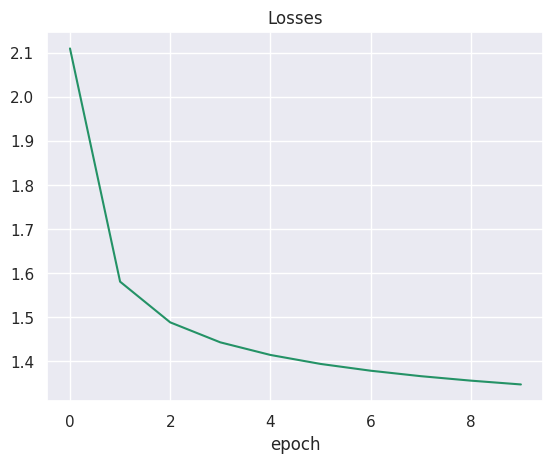

In [21]:
plt.plot(np.arange(len(losses)), losses)
plt.title('Losses')
plt.xlabel("epoch")
plt.show()

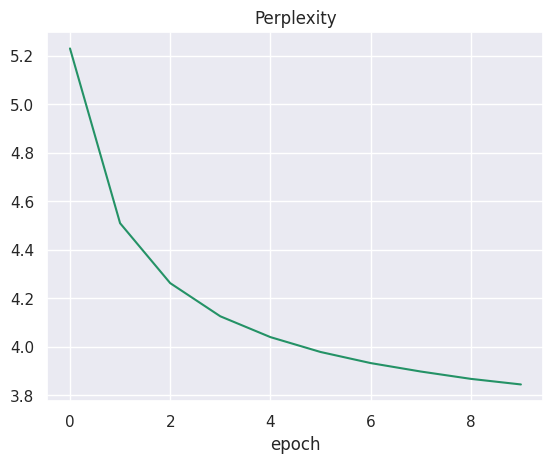

In [22]:
plt.plot(np.arange(len(perplexities)), perplexities)
plt.title('Perplexity')
plt.xlabel("epoch")
plt.show()

## Generation

In [49]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cpu'
    model = model.to(device)
    input_ids = [char2ind['<bos>']] + [
        char2ind.get(char, char2ind['<unk>']) for char in starting_seq]
    input_ids = torch.LongTensor(input_ids).to(device)
    
    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_char_distribution = model(input_ids)[-1]
            next_char = next_char_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_char.unsqueeze(0)])
            print(ind2char[next_char.item()])
            if next_char.item() == char2ind['<eos>']:
                break
            
    words = ''.join([ind2char[idx.item()] for idx in input_ids])

    return words

In [137]:
generate_sequence(model, starting_seq='по системе гол лучшим является ')

в
 
с
о
с
т
а
в
л
я
е
т
 
п
о
д
о
б
н
ы
е
 
п
о
л
и
т
и
к
а
 
и
 
п
о
д
о
б
н
ы
е
 
п
о
л
и
т
и
к
а
 
и
 
п
о
д
о
б
н
ы
е
 
п
о
л
и
т
и
к
а
 
и
 
п
о
д
о
б
н
ы
е
 
п
о
л
и
т
и
к
а
 
и
 
п
о
д
о
б
н
ы
е
 
п
о
л
и
т
и
к
а
 
и
 
п
о
д
о
б
н
ы
е
 
п
о
л
и
т
и


'<bos>по системе гол лучшим является в составляет подобные политика и подобные политика и подобные политика и подобные политика и подобные политика и подобные полити'